In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
torch.manual_seed(0)
from sklearn.decomposition import PCA 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# MNIST DATA

In [3]:
transform = transforms.Compose([transforms.RandomRotation(15),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                               ])

valid_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                               ])


trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=150, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)
print(len(trainloader))

400


In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,10)
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        #x = F.log_softmax(self.fc3(x), dim=1)       
        return x

In [14]:
step = 0
iters = 8
epoch = 45
modelweights = []
layer1 = []
costVector = []
accVector = []

for i in range(iters):
    print("\n========================Iteration"+str(i+1)+"========================")
    model = DNN()
    model.to(device)
    optimize = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.NLLLoss()
    
    for e in range(epoch+1):
        model.train()
        train_loss, train_acc = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimize.zero_grad()
            logps = model(images) #forward propagation
            loss = loss_fn(logps, labels) #calculate loss
            train_loss+=loss.item()

            _, pred = logps.max(1)
            train_acc += (pred == labels).sum()

            loss.backward() #backward propagation
            optimize.step() #update weights

        tloss = train_loss/len(trainloader)
        tacc = train_acc/len(trainset)

        if e%15==0:
            print("Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.2f}".format(e, tloss, tacc))

        if e%3==0:
                modelweight = model.parameters()
                w1 = model.fc1.weight.flatten()
                w2 = model.fc2.weight.flatten()
                w3 = model.fc3.weight.flatten()
                layers = torch.cat((w1.reshape(1,w1.shape[0]),
                                    w2.reshape(1,w2.shape[0]),
                                    w3.reshape(1,w3.shape[0])),dim=1)
                #layer1Weights = torch.reshape(torch.flatten(model.fc1.weight), (1, 7))
                modelweights.append(layers[0].detach().tolist())
                layer1.append(w1.detach().tolist())
                costVector.append(loss.item())
                accVector.append(tacc)


========================Iteration1========================
Epoch: 0  Train Loss: 0.8793  Train Accuracy: 0.72
Epoch: 15  Train Loss: 0.2619  Train Accuracy: 0.92
Epoch: 30  Train Loss: 0.2130  Train Accuracy: 0.93
Epoch: 45  Train Loss: 0.1896  Train Accuracy: 0.94

========================Iteration2========================
Epoch: 0  Train Loss: 0.9028  Train Accuracy: 0.71
Epoch: 15  Train Loss: 0.2768  Train Accuracy: 0.91
Epoch: 30  Train Loss: 0.2210  Train Accuracy: 0.93
Epoch: 45  Train Loss: 0.1977  Train Accuracy: 0.94

========================Iteration3========================
Epoch: 0  Train Loss: 0.8593  Train Accuracy: 0.73
Epoch: 15  Train Loss: 0.2406  Train Accuracy: 0.92
Epoch: 30  Train Loss: 0.1990  Train Accuracy: 0.94
Epoch: 45  Train Loss: 0.1802  Train Accuracy: 0.94

========================Iteration4========================
Epoch: 0  Train Loss: 0.8395  Train Accuracy: 0.73
Epoch: 15  Train Loss: 0.2324  Train Accuracy: 0.93
Epoch: 30  Train Loss: 0.1898  Train

In [15]:
#convert lists to numpy array
modelweights = np.asarray(modelweights)
layer1 = np.asarray(layer1)
accVector = np.asarray(accVector)

#Reduce weights dimension to 2 using PCA Function
pca = PCA(n_components=2)
wholeModelPCA = pca.fit_transform(modelweights)
layer1PCA = pca.fit_transform(layer1)
print(len(wholeModelPCA))

128


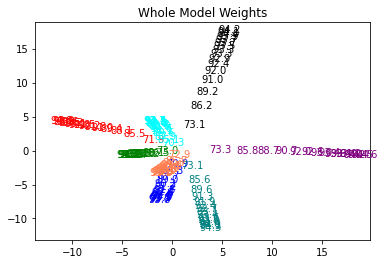

In [18]:
color = ["red", "blue", "green", "purple", "cyan", "teal", 'black','coral']

#PCA plot for the weights of the whole model after 8 iterations
j = 0
for i, pair in enumerate(wholeModelPCA):
    plt.plot(pair[0], pair[1], color[j])
    plt.annotate(str(round(accVector[i].item()*100, 1)), (pair[0], pair[1]), color=color[j])
    #Use a different color for another event
    if ((i+1) % 16) == 0:
        j += 1
plt.title("Whole Model Weights") 
plt.savefig('wholeweight.png')
plt.show()

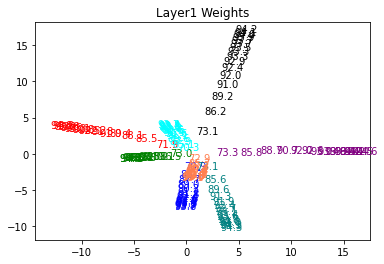

In [19]:

#PCA plot for the weights of layer 2 after 8 iterations
j = 0
for i, pair in enumerate(layer1PCA):
    plt.plot(pair[0], pair[1], color[j])
    plt.annotate(str(round(accVector[i].item()*100, 1)), (pair[0], pair[1]), color=color[j])
    #Use a different color for another event
    if ((i+1) % 16) == 0:
        j += 1
plt.title("Layer1 Weights") 
plt.savefig('layer1weight.png')
plt.show()